# import library

In [1]:
# origin library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

import librosa

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import StratifiedKFold



import warnings
warnings.filterwarnings("ignore")

c:\Users\BOIL_PO\.conda\envs\jou_pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


# function define

In [2]:
# 官方提供之前處理函數
def medical_data_proccessing(df):
    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

In [3]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [23]:
# training dataset
class CustomImageDataset(Dataset):
    def __init__(self, source_df, transform=None, target_transform=None):

        self.dataframe = source_df
        self.transform = transform
        self.target_transform = target_transform

        self.medical = self.dataframe.drop(columns= ['ID', 'mfcc_path', 'Disease category'])
        self.path = self.dataframe['mfcc_path']
        self.label_df = self.dataframe['Disease category']
        


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_path = self.path.iloc[idx]
        
        mfcc_img = np.load(img_path)
        mfcc_img = standardization(mfcc_img)

        medicals = self.medical.iloc[idx].values

        label = self.label_df.iloc[idx]

        if self.transform:
            mfcc_img = self.transform(mfcc_img)

        if self.target_transform:
            label = self.target_transform(label)
        
        # return medicals 
        return mfcc_img, medicals, label, img_path

In [24]:
# public and private dataset
class CustomImageDataset_public(Dataset):
    def __init__(self, source_df, transform=None, target_transform=None):
        
        self.dataframe = source_df
        self.transform = transform
        self.target_transform = target_transform

        self.medical = self.dataframe.drop(columns= ['ID', 'mfcc_path'])
        self.path = self.dataframe['mfcc_path']
        self.id = self.dataframe['ID']
    

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
                
        img_path = self.path.iloc[idx]
        
        mfcc_img = np.load(img_path)
        mfcc_img = standardization(mfcc_img)

        medicals = self.medical.iloc[idx].values                

        ids = self.id.iloc[idx]            

        if self.transform:
            mfcc_img = self.transform(mfcc_img)

        if self.target_transform:
            label = self.target_transform(label)
        
        # return medicals 
        return mfcc_img, medicals, ids

In [25]:
# set torch device
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [26]:
class Network(nn.Module):
    def __init__(self, pool = 1, fc1=128, maxpool=2):
        super(Network, self).__init__()
        # CNN - MFCC圖片
        self.maxpool = maxpool

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)        
        self.pool1 = nn.MaxPool2d(self.maxpool, padding= 1)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 10), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(self.maxpool, padding= 1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 10), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(self.maxpool, padding= 1)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)   
        self.pool4 = nn.MaxPool2d(self.maxpool, padding= 1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        
        # Avg pool 
        self.pools = pool        
        self.ave_pool = nn.AdaptiveAvgPool2d(self.pools)


        # MLP - 生理資訊
        self.linear1= nn.Linear(44, 1024)
        self.l1 = nn.BatchNorm1d(1024)
        # self.dropmlp = nn.Dropout(0.1)
        self.linear2= nn.Linear(1024, 256) 
        self.l2 = nn.BatchNorm1d(256)
        self.linear3= nn.Linear(256, 128)
        
        # FC - 分類用
        self.fc1_num = fc1
        self.fc1 = nn.Linear(64*self.pools*self.pools + 128, self.fc1_num)
        self.bnfc = nn.BatchNorm1d(self.fc1_num)
        self.fc2 = nn.Linear(self.fc1_num, 5)
        self.soft = nn.Softmax(dim=1)
        self.drop = nn.Dropout(0.3)


    def forward(self, input1, medical_in):
        # cnn
        output = F.celu(self.conv1(input1))
        output = self.bn1(output)
        output = self.pool1(output) 

        output = F.celu(self.conv2(output))     
        output = self.bn2(output)
        output = self.pool2(output)

        output = F.celu(self.conv3(output)) 
        output = self.bn3(output)
        output = self.pool3(output)   

        output = self.ave_pool(output)
        output = output.view(-1, 64*self.pools*self.pools)

        # medical data
        x = F.celu(self.linear1(medical_in))
        x = F.celu(self.linear2(x))
        x = F.celu(self.linear3(x))
        
        # concat
        con = torch.cat((output, x), 1)    
        con = F.celu(self.fc1(con))
        # con  = self.drop(con)
        con = self.bnfc(con)
        con = self.fc2(con)           
        con = self.soft(con)

        return con

# Training

In [27]:
# read csv data
source_df = pd.read_csv(r'..\Training_Dataset\training_datalist.csv')
source_df['mfcc_path'] = source_df['ID'].apply(lambda x:f'..\\Training_Dataset\\training_voice_data\\{x}_mfcc_30.npy')

# data preprocessing
source_df_pro = medical_data_proccessing(source_df)
source_df_pro = pd.get_dummies(source_df_pro, columns=['Smoking', 'frequency', 'Onset of dysphonia ', 'Noise at work', 'Diurnal pattern', 'Occupational vocal demand'])
source_df_pro['Disease category'] = source_df_pro['Disease category'] - 1

In [28]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True)
fold1 = list(skf.split(source_df_pro, source_df_pro['Disease category']))[0]

training_df = source_df_pro.loc[fold1[0]]
test_df = source_df_pro.loc[fold1[1]]
print("training_df shape :", training_df.shape, ", test_df shape :", test_df.shape)

# 計算每一類的數量，讓CrossEntropyLoss做使用
numberlist = training_df['Disease category'].value_counts().sort_index().to_list()
print(training_df['Disease category'].value_counts().sort_index())

training_df shape : (750, 47) , test_df shape : (250, 47)
0    402
1    165
2    126
3     33
4     24
Name: Disease category, dtype: int64


In [29]:
# dataset and dataloader
trans_comp = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomImageDataset(training_df, transform= trans_comp)
test_dataset = CustomImageDataset(test_df, transform= trans_comp)
train_dl = DataLoader(train_dataset, batch_size= 32, shuffle= True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size= 32, shuffle= False)

In [30]:
# model 
model = Network().to(device)

# optimizer
weight = torch.tensor([1/numberlist[0], 1/numberlist[1], 1/numberlist[2], 1/numberlist[3], 1/numberlist[4]]).to(device)
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = SGD(model.parameters(), lr=0.01, weight_decay= 0.0001)

In [ ]:
# train
train_acc_list = [0]
test_acc_list = [0]
before_acc = 0.

# epoch
epoch = 150

for epoch in range(epoch):
    predict_save = []
    label_save = []
    losses = 0.  
    
    # training dataset
    for batch, (np_araay, medicals, label, img_path) in enumerate(train_dl):
        model.train()
        
        inputs, medicals, labels = np_araay.float().to(device), medicals.float().to(device), label.to(device)
        optimizer.zero_grad()
        pred_out = model(inputs, medicals)
        
        loss = criterion(pred_out, labels)
        losses = losses + loss.item()

        loss.backward()
        optimizer.step()

        digital = list(pred_out.cpu().argmax(1))
        train_label = list(label.cpu())
        
        predict_save += digital
        label_save += train_label

    y_pred = [x.item() for x in predict_save]
    y_true = [cc.item() for cc in label_save]

    results_recall = recall_score(y_true, y_pred, average=None)
    train_mean = results_recall.mean()
    train_acc_list.append(train_mean)
    # print("Training UAR(Unweighted Average Recall) :", train_mean)

    # validation dataset
    pre_save_test = []
    label_save_test = []
    model.eval()
    with torch.no_grad():
        for np_araay, medicals, label, img_path in test_dl:
            inputs, medicals, labels = np_araay.float().to(device), medicals.float().to(device), label.to(device)

            pred = model(inputs, medicals)
            
            digital = list(pred.cpu().argmax(1))
            lab = list(labels.cpu())
            
            pre_save_test += digital
            label_save_test += lab

    y_predt = [x.item() for x in pre_save_test]
    y_truet = [cc.item() for cc in label_save_test]

    results_recallt = recall_score(y_truet, y_predt, average=None)
    test_mean = results_recallt.mean()
    test_acc_list.append(test_mean)
    # print("Test UAR(Unweighted Average Recall) :", test_mean)

    # 存model
    if test_mean > before_acc:
        before_acc = test_mean
        torch.save(model.state_dict(), "{}.pth".format("mfcc21_use_all"))


In [ ]:
# 畫出結果圖
plt.figure(figsize= (10,5))
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label= 'Train_recall')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label= 'Test_recall')
plt.legend(fontsize= 15)
plt.xlabel('Epochs')
plt.ylabel('Mean Recall')
plt.title('Recall Plot', fontsize= 15)
plt.show()

# Load Best Model

In [31]:
model.load_state_dict(torch.load("{}.pth".format("mfcc30_use_all")))

<All keys matched successfully>

In [32]:
pre_save_test = []
label_save_test = []
model.eval()
with torch.no_grad():
    for np_araay, medicals, label, img_path in test_dl:
        inputs, medicals, labels = np_araay.float().to(device), medicals.float().to(device), label.to(device)

        pred = model(inputs, medicals)
        
        digital = list(pred.cpu().argmax(1))
        lab = list(labels.cpu())
        
        pre_save_test += digital
        label_save_test += lab

y_predt = [x.item() for x in pre_save_test]
y_truet = [cc.item() for cc in label_save_test]

results_recallt = recall_score(y_truet, y_predt, average=None)
test_mean = results_recallt.mean()
print("Test UAR(Unweighted Average Recall) :", test_mean)

Test UAR(Unweighted Average Recall) : 0.7825948181172062


Training UAR(Unweighted Average Recall) : 0.7825948181172062


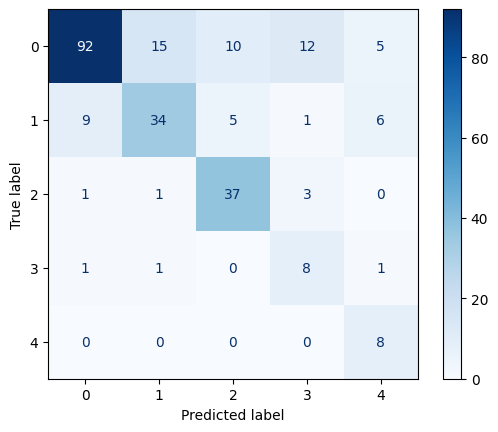

In [33]:
results_recall = recall_score(y_truet, y_predt, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())
cm = confusion_matrix(y_truet, y_predt)
ConfusionMatrixDisplay(confusion_matrix(y_truet, y_predt)).plot(cmap='Blues')

# Predict - public data

In [34]:
# load public csv
data_df = pd.read_csv(r'..\Public_Testing_Dataset\test_datalist_public.csv')
data_df['mfcc_path'] = data_df['ID'].apply(lambda x: f'..\\Public_Testing_Dataset\\test_data_public\\{x}_mfcc_30.npy')

# preprocessing of public csv
data_df_pro = medical_data_proccessing(data_df)
data_df_pro = pd.get_dummies(data_df_pro, columns=['Smoking', 'frequency', 'Onset of dysphonia ', 'Noise at work', 'Diurnal pattern', 'Occupational vocal demand'])

In [35]:
trans_comp = transforms.Compose([transforms.ToTensor()])
pub_dataset = CustomImageDataset_public(data_df_pro, transform= trans_comp)
pub_dl = DataLoader(pub_dataset, batch_size= 32, shuffle= False)
print(pub_dataset.__len__())

500


In [36]:
pub_save = []
id_list = []
model.eval()
with torch.no_grad():
    for np_araay, medicals, img_path in pub_dl:
        inputs, medicals= np_araay.float().to(device), medicals.float().to(device)
        # print(inputs.shape)
        pred = model(inputs, medicals)
        
        digital = list(pred.cpu())
           
        pub_save += digital
        id_list += img_path
   

y_pub = [x.numpy() for x in pub_save]
y_pub[:5]

[array([0.21529484, 0.00130057, 0.00283265, 0.7777455 , 0.00282641],
       dtype=float32),
 array([5.6947106e-01, 2.0448371e-05, 9.9616461e-03, 4.1507334e-01,
        5.4735229e-03], dtype=float32),
 array([4.1199935e-05, 1.6537384e-03, 9.5880294e-01, 3.0932523e-02,
        8.5695758e-03], dtype=float32),
 array([0.83786017, 0.01546933, 0.00721223, 0.03448887, 0.10496945],
       dtype=float32),
 array([0.00375493, 0.01566837, 0.4553659 , 0.01464612, 0.5105647 ],
       dtype=float32)]

# Predict - private data

In [37]:
# load private data
data_private_df = pd.read_csv(r'..\Private_Testing_Dataset\test_datalist_private.csv')
data_private_df['mfcc_path'] = data_private_df['ID'].apply(lambda x: f'..\\Private_Testing_Dataset\\test_data_private\\{x}_mfcc_30.npy')

# preprocessing of private data
data_private_pro = medical_data_proccessing(data_private_df)
data_private_pro = pd.get_dummies(data_private_pro, columns=['Smoking', 'frequency', 'Onset of dysphonia ', 'Noise at work', 'Diurnal pattern', 'Occupational vocal demand'])

In [38]:
trans_comp = transforms.Compose([transforms.ToTensor()])
pri_dataset = CustomImageDataset_public(data_private_pro, transform= trans_comp)
pri_dl = DataLoader(pri_dataset, batch_size= 32, shuffle= False)
print(pri_dataset.__len__())

500


In [39]:
pub_save_private = []
id_list_private = []
model.eval()
with torch.no_grad():
    for np_araay, medicals, img_path in pri_dl:
        inputs, medicals= np_araay.float().to(device), medicals.float().to(device)
        # print(inputs.shape)
        pred = model(inputs, medicals)
        
        digital = list(pred.cpu())
           
        pub_save_private += digital
        id_list_private += img_path
   

y_pri = [x.numpy() for x in pub_save_private]
y_pri[:5]

[array([3.1013114e-05, 9.9880600e-01, 5.3017482e-04, 3.3394780e-04,
        2.9877646e-04], dtype=float32),
 array([0.0140836 , 0.84544903, 0.12275959, 0.00504107, 0.01266672],
       dtype=float32),
 array([0.25844252, 0.29270104, 0.21392135, 0.18834719, 0.04658784],
       dtype=float32),
 array([6.3480111e-03, 8.7411153e-01, 6.4827204e-02, 5.4274298e-02,
        4.3894586e-04], dtype=float32),
 array([1.4181702e-06, 8.2804738e-03, 9.9114883e-01, 5.4686214e-04,
        2.2455004e-05], dtype=float32)]

# Combine

In [40]:
y_all = y_pub + y_pri
print(len(y_all))

1000


In [41]:
mmffcc30 = np.array(y_all)
np.save('output_mfcc30.npy', mmffcc30)